In [1917]:
import os
import zipfile
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Считывание словаря

In [1967]:
# десериализация словаря
with open('token_to_id.pickle', 'rb') as file:
    token_to_id = pickle.load(file)

### Создание Dataset и Dataloader

In [1966]:
%load_ext autoreload
%autoreload 2

from dataloader import LipReadingVideoDataset, get_vframes, collate_func

In [1960]:
# path to dataset
trainval_data_path = os.path.normpath('data/lrs3_trainval.zip')
test_data_path = os.path.normpath('data/lrs3_test_v0.4.zip')

In [1898]:
# transforms for video
from torchvideotransforms import video_transforms

flip = video_transforms.RandomHorizontalFlip(p=0.5)
rotation = video_transforms.RandomRotation(degrees=15)

transform = video_transforms.Compose([flip, rotation])

In [1948]:
# tokenizer for sentences
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [1961]:
batch = 2

# load trainval
trainval_ds = LipReadingVideoDataset(trainval_data_path, transform=transform, tokenizer=tokenizer)

N = len(trainval_ds)
train_N = int(0.9*N)
val_N = N - train_N
train_ds, val_ds = torch.utils.data.random_split(trainval_ds, (train_N, val_N), 
                                                 generator=torch.Generator().manual_seed(42))

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch, shuffle=True, collate_fn=collate_func)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch, shuffle=True, collate_fn=collate_func)

# load test
test_ds = LipReadingVideoDataset(test_data_path, transform=transform)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch, shuffle=True, collate_fn=collate_func)

### Network

In [1906]:
%load_ext autoreload
%autoreload 2

from network import LipReadinNN
from network_small import LipReadinNN_LSTM
from model_train_functions import train_model, test_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1907]:
# создаем модель 
lip_reading_nn = LipReadinNN_LSTM(token_to_id)

opt = torch.optim.Adam(lip_reading_nn.parameters(), lr=0.001)

In [1835]:
# или загружаем модель
PATH = 'lip_reading/model_0.pt'
device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')

lip_reading_nn = LipReadinNN_LSTM(token_to_id)
lip_reading_nn.load_state_dict(torch.load(PATH))
lip_reading_nn.to(device)

opt = torch.optim.Adam(lip_reading_nn.parameters(), lr=0.001)

RuntimeError: Error(s) in loading state_dict for LipReadinNN_LSTM:
	size mismatch for embedding.weight: copying a param with shape torch.Size([17193, 1024]) from checkpoint, the shape in current model is torch.Size([17193, 512]).
	size mismatch for LSTM1.weight_ih_l0: copying a param with shape torch.Size([8192, 512]) from checkpoint, the shape in current model is torch.Size([4096, 512]).
	size mismatch for LSTM1.weight_hh_l0: copying a param with shape torch.Size([8192, 2048]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for LSTM1.bias_ih_l0: copying a param with shape torch.Size([8192]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for LSTM1.bias_hh_l0: copying a param with shape torch.Size([8192]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for LSTM1.weight_ih_l1: copying a param with shape torch.Size([8192, 2048]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for LSTM1.weight_hh_l1: copying a param with shape torch.Size([8192, 2048]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for LSTM1.bias_ih_l1: copying a param with shape torch.Size([8192]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for LSTM1.bias_hh_l1: copying a param with shape torch.Size([8192]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for LSTM2.weight_ih_l0: copying a param with shape torch.Size([4096, 2048]) from checkpoint, the shape in current model is torch.Size([2048, 1024]).
	size mismatch for LSTM2.weight_hh_l0: copying a param with shape torch.Size([4096, 1024]) from checkpoint, the shape in current model is torch.Size([2048, 512]).
	size mismatch for LSTM2.bias_ih_l0: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for LSTM2.bias_hh_l0: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for LSTM2.weight_ih_l1: copying a param with shape torch.Size([4096, 1024]) from checkpoint, the shape in current model is torch.Size([2048, 512]).
	size mismatch for LSTM2.weight_hh_l1: copying a param with shape torch.Size([4096, 1024]) from checkpoint, the shape in current model is torch.Size([2048, 512]).
	size mismatch for LSTM2.bias_ih_l1: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for LSTM2.bias_hh_l1: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for LSTM_decoder.weight_ih_l0: copying a param with shape torch.Size([4096, 1024]) from checkpoint, the shape in current model is torch.Size([2048, 512]).
	size mismatch for LSTM_decoder.weight_hh_l0: copying a param with shape torch.Size([4096, 1024]) from checkpoint, the shape in current model is torch.Size([2048, 512]).
	size mismatch for LSTM_decoder.bias_ih_l0: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for LSTM_decoder.bias_hh_l0: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for linear.weight: copying a param with shape torch.Size([17193, 1024]) from checkpoint, the shape in current model is torch.Size([17193, 512]).

train step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||val step
test step
test cycle step
test cycle step
test cycle step
test cycle step
test cycle step
test cycle step
mean loss on train: 	4.336970650323547
mean loss on val: 	6.143784364064534
||||

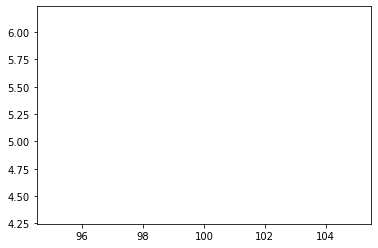

KeyboardInterrupt: 

In [1908]:
# обучение
device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')
epoch = 3

for e in range(epoch):
    train_loss, val_loss = train_model(model=lip_reading_nn, 
                                   train_dataloader=train_dl, 
                                   val_dataloader=val_dl, 
                                   optimizer=opt, 
                                   device=device)
    
    test_loss = test_model(model=lip_reading_nn, 
                           test_dataloader=test_dl, 
                           device=device)
    
    print('')
    print(f'EPOCH {e} is ended')
    print(f'last mean loss on train: \t{train_loss[-1]}')
    print(f'last mean loss on val: \t{val_loss[-1]}')
    print(f'mean loss on test: \t{np.array(test_loss).mean()}', end='\n')

### Проверки

In [1914]:
lip_reading_nn.loss

tensor(6.6580, grad_fn=<NllLoss2DBackward>)

In [1962]:
for i, (vframes_batch, list_of_tokens) in enumerate(train_dl):
    print(vframes_batch.shape)
    if i >= 0:
        break

torch.Size([2, 5, 128, 3, 224, 224])


In [1911]:
device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')
vframes_batch = vframes_batch.to(device)

lip_reading_nn.train(False)
lip_reading_nn.to(device)

output = lip_reading_nn(vframes_batch, list_of_tokens)

In [1915]:
# сохраняем модель
PATH = 'model_.pt'

torch.save(lip_reading_nn.state_dict(), PATH)